# Topic Modeling on CORD-19 Dataset


<div style="width: 300px;">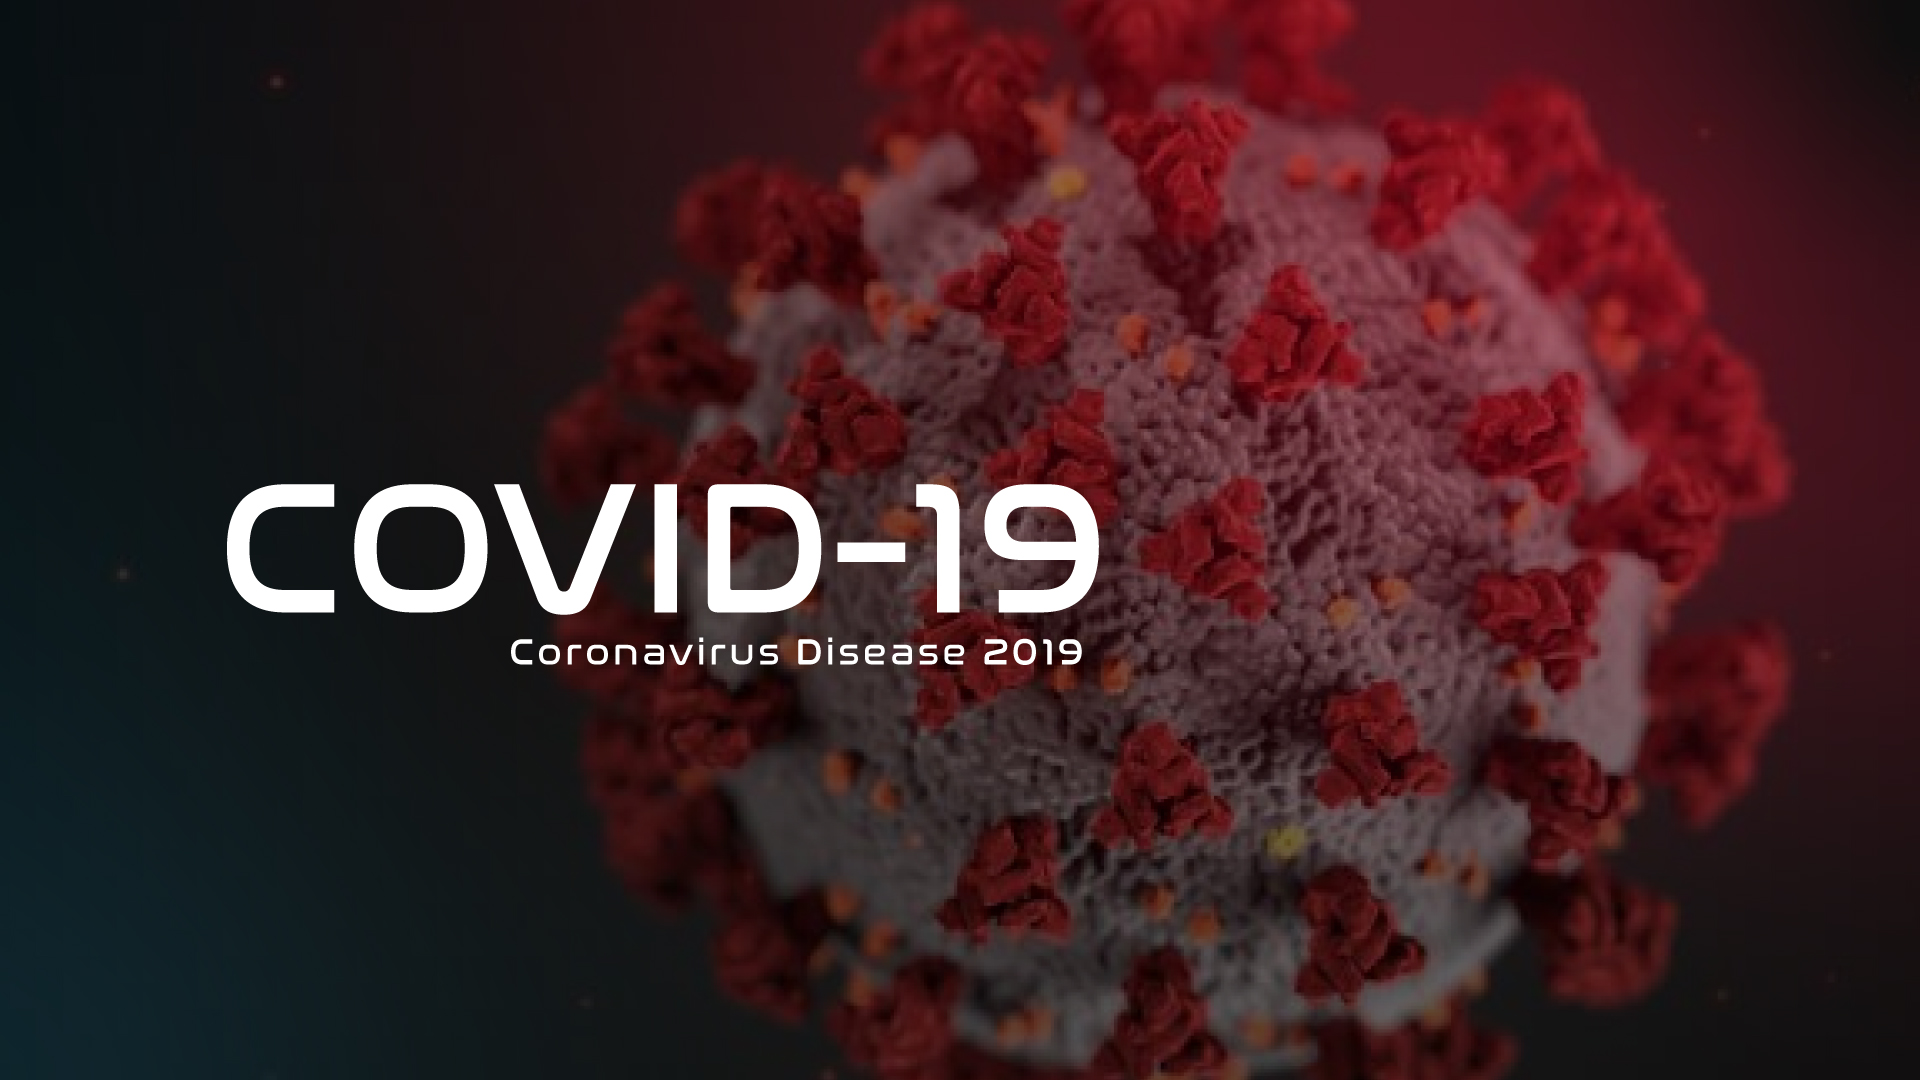</div>


## Goal 
The goal of the project was to take the dataset https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge and apply unsupervised techniques in NLP such as Topic Modeling for
- Understanding the latent topics in the corpus
- Relationships between top words and the topics uncovered and visualize them
- Help Classifier based Tools like Cognition to view Topics and lexicons (words) for classification task.
- Document to Topic mapping for facilitating search in the topic sub-space


## Outputs and Results
Following things were accomplished and outputs are generated in the output files
- Vectorizing the corpus using Frequency Based technique (data_vectorized.dmp, vectorizer.dmp) for reuse and any technqiues
- Basic EDA such as top words based on frequency (removing additional stop words)
- Fitting Non-Negative Matrix Factorization (NMF) for Topic Modeling (nmf.dmp) for analysis
- Fitting Latent Dirichlet Alloation (LDA) for Topic Modeling (lda.dmp) for analysis
- Visualizing LDA and NMF using LDAVis (lda4topics_v2.html)
- Using Search with K-Nearest Neighbors Technique on the Topic Sub-Space using Jensen-Shannon Divergence  

# Library Imports

In [74]:
import numpy as np 
import pandas as pd

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import spacy
from scipy.spatial.distance import jensenshannon

import joblib
from IPython.display import HTML, display

from ipywidgets import interact, Layout, HBox, VBox, Box
import ipywidgets as widgets
from IPython.display import clear_output

from tqdm import tqdm
from os.path import isfile

import seaborn as sb
import matplotlib.pyplot as plt

# Dataset

In [75]:
data_path = "./input/"
outputs_path = "./outputs/"

In [76]:
df = joblib.load(data_path + 'cord19_df.dmp')

In [77]:
df.head()

,paper_id,body_text,methods,results,cord_uid,source_x,title,doi,pmcid,pubmed_id,...,has_full_text,full_text_file,url,publish_year,is_covid19,text_language,study_abstract,study_methods,study_results,study_design
0,053bbe38ee5f3c97ade5b24a07b34b9930d3f474,mathematically and computed models are establi...,Computational methods take an interdisciplinar...,NaN,egd1gxby,Elsevier,Chapter 21 In Silico Models From Simple Networ...,10.1016/b978-0-12-416002-6.00021-3,NaN,NaN,...,True,custom_license,https://doi.org/10.1016/b978-0-12-416002-6.000...,2014,False,en,set(),set(),set(),set()
1,060f83d466d0f77513f8e3d2b55e149894211b64,Acute respiratory tract infection (ARTI) is a ...,NaN,We investigated a population of 324 specimens ...,092cd8ap,Elsevier,Evidence of human coronavirus HKU1 and human b...,10.1016/j.jcv.2005.09.008,NaN,16257260.0,...,True,custom_license,https://doi.org/10.1016/j.jcv.2005.09.008,2006,False,en,"{'incidence', 'etiology'}",set(),{'prevalence'},"{'incidence', 'etiology', 'prevalence'}"
2,ce19f6664fc109d488b095746ef87195906df39d,The medical use of stem cells promises profoun...,NaN,NaN,hc359qwn,Elsevier,73 Stem Cell-based Products in Medicine: FDA R...,10.1016/b978-012436643-5/50163-2,NaN,NaN,...,True,custom_license,https://doi.org/10.1016/b978-012436643-5/50163-2,2004,False,en,set(),set(),set(),set()
3,7eb12441cad340422ae9898395921454bbd3d5db,As the so-called Spanish flu raged around the ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1,False,en,set(),set(),set(),set()
4,c83346b9e5e45cc987f59be4e9ad1e63c483ac9a,Viruses continue to pose an important biomedic...,"For each member of the protein family, we crea...",The postfusion ensembles should be thermodynam...,38pb1bti,PMC,Rotation-Activated and Cooperative Zipping Cha...,10.1016/j.bpj.2018.03.005,PMC5937144,29694865.0,...,True,custom_license,http://www.cell.com/article/S0006349518303229/pdf,2018,False,en,set(),set(),set(),set()


In [78]:
df.shape

(32619, 27)

# Data Preprocessing

In [ ]:
import scispacy
import spacy
import en_core_sci_lg

In [ ]:
# medium model
nlp = en_core_sci_lg.load(disable=["tagger", "parser", "ner"])
nlp.max_length = 2000000

In [85]:
def spacy_tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)]

In [ ]:
# stop words list 
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI',
    '-PRON-'
]

# Mark them as stop words
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True


In [90]:
if not (isfile(outputs_path + 'vectorizer.dmp') & isfile(outputs_path + 'data_vectorized.dmp')):
    print('Files not there: generating')
    vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, max_features=800000)
    data_vectorized = vectorizer.fit_transform(tqdm(all_texts))
    joblib.dump(vectorizer, outputs_path+ 'vectorizer.dmp')
    joblib.dump(data_vectorized, outputs_path+ 'data_vectorized.dmp')
else:
    vectorizer = joblib.load(outputs_path + 'vectorizer.dmp')
    data_vectorized = joblib.load(outputs_path + 'data_vectorized.dmp')

/Users/uday.kamath/anaconda/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.22.2.post1 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Most Frequent Words in the Corpus

In [91]:
# most frequent words
word_count = pd.DataFrame({'word': vectorizer.get_feature_names(), 'count': np.asarray(data_vectorized.sum(axis=0))[0]})
word_count.sort_values('count', ascending=False).set_index('word')[:25].sort_values('count', ascending=True).plot(kind='barh')

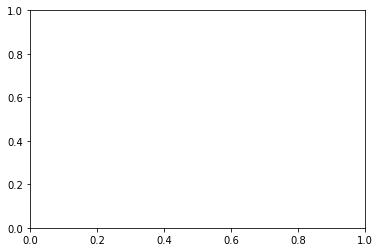

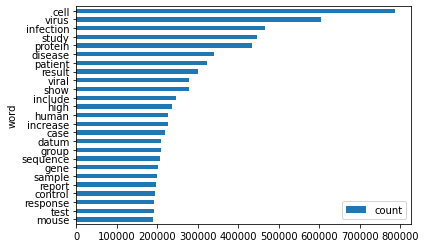

In [92]:
plt.show()

# Non-negative Matrix Factorization (NMF) for Topic Modeling 

<div style="width: 600px;">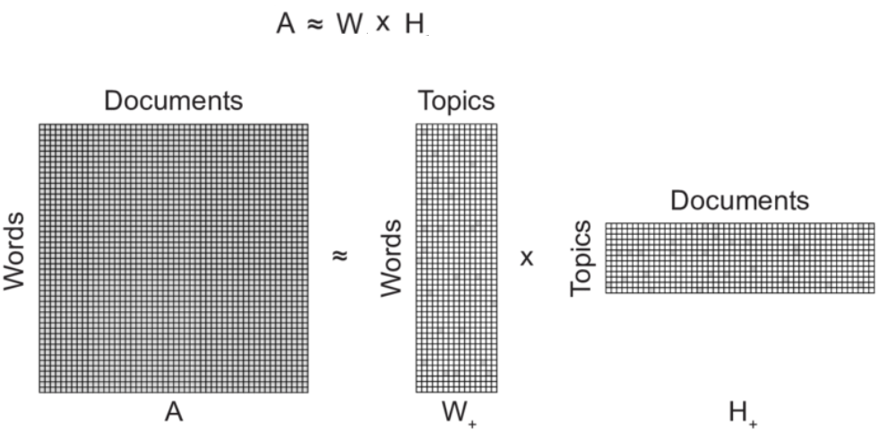</div>

In [13]:
from time import time

from sklearn.decomposition import NMF
# Fit the NMF model
t0 = time()
nmf = NMF(n_components=10, random_state=1,
          alpha=.1, l1_ratio=.5).fit(data_vectorized)
print("done in %0.3fs." % (time() - t0))

done in 175.591s.


In [19]:
nmf_feature_names = vectorizer.get_feature_names()
nmf_weights = nmf.components_

In [20]:
nmf_output = nmf.fit_transform(data_vectorized)

In [23]:
#####################################
## Utility functions to help with NMF
# Code adapted from Sarkar text book
#####################################

# get topics with their terms and weights
def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    sorted_indices = np.array([list(row[::-1]) for row in np.argsort(np.abs(weights))])
    sorted_weights = np.array([list(wt[index]) for wt, index in zip(weights, sorted_indices)])
    sorted_terms = np.array([list(feature_names[row]) for row in sorted_indices])

    topics = [np.vstack((terms.T, term_weights.T)).T for terms, term_weights in zip(sorted_terms, sorted_weights)]

    return topics


# prints components of all the topics
# obtained from topic modeling
def print_topics_udf(topics, total_topics=1,
                     weight_threshold=0.0001,
                     display_weights=False,
                     num_terms=None):

    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        #print(topic)
        topic = [(word, round(wt,2))
                 for word, wt in topic
                 if abs(wt) >= weight_threshold]

        if display_weights:
            print('Topic #'+str(index+1)+' with weights')
            print(topic[:num_terms]) if num_terms else topic
        else:
            print('Topic #'+str(index+1)+' without weights')
            tw = [term for term, wt in topic]
            print(tw[:num_terms]) if num_terms else tw

# prints components of all the topics
# obtained from topic modeling
def get_topics_udf(topics, total_topics=1,
                     weight_threshold=0.0001,
                     num_terms=None):

    topic_terms = []

    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        #print(topic)
        topic = [(word, round(wt,2))
                 for word, wt in topic
                 if abs(wt) >= weight_threshold]

        topic_terms.append(topic[:num_terms] if num_terms else topic)

    return topic_terms

def get_terms_and_sizes(topic_display_list_item):
    terms = []
    sizes = []
    for term, size in topic_display_list_item:
        terms.append(term)
        sizes.append(size)
    return terms, sizes

In [22]:
topics = get_topics_terms_weights(nmf_weights, nmf_feature_names)
print_topics_udf(topics, total_topics=10, num_terms=30, display_weights=True)

Topic #1 with weights
[('patient', 96.78), ('study', 28.41), ('result', 21.08), ('group', 20.69), ('method', 15.31), ('treatment', 14.85), ('level', 14.32), ('asthma', 14.1), ('conclusion', 13.51), ('test', 13.36), ('clinical', 12.87), ('year', 12.85), ('increase', 12.34), ('child', 12.29), ('high', 12.1), ('hospital', 11.33), ('symptom', 10.63), ('day', 10.58), ('age', 10.4), ('disease', 10.32), ('infection', 10.18), ('case', 10.17), ('allergic', 10.09), ('include', 9.34), ('blood', 9.1), ('compare', 8.77), ('control', 8.55), ('associate', 8.31), ('therapy', 8.28), ('icu', 7.98)]
Topic #2 with weights
[('cell', 87.35), ('mouse', 22.5), ('expression', 14.82), ('response', 13.05), ('immune', 9.08), ('antibody', 9.04), ('induce', 8.89), ('increase', 7.97), ('show', 7.91), ('ms', 7.9), ('effect', 7.55), ('receptor', 7.46), ('gene', 7.44), ('level', 7.28), ('study', 7.21), ('control', 7.19), ('express', 7.0), ('role', 6.97), ('disease', 6.95), ('activation', 6.76), ('cytokine', 6.67), ('hu

In [24]:
doc_topic_dist = pd.DataFrame(nmf.transform(data_vectorized))
doc_topic_dist.to_csv('doc_topic_dist.csv', index=False)

In [35]:
doc_topic_dist.head()

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.828182,0.333651,0.000000,0.571585,1.502707,0.000000,0.073777,0.789028,0.355818
1,0.105301,0.000000,0.042807,0.210283,0.000000,0.018713,0.022852,0.006388,0.281437,0.017890
2,0.059977,1.712140,0.000000,0.097614,0.000000,0.357545,0.000000,0.184331,0.233157,0.000000
3,0.166082,0.185224,0.300793,0.444513,0.011841,0.000000,0.000000,0.030687,0.277659,0.000000
4,0.000000,0.000000,0.000000,0.373781,1.490612,0.067708,0.000000,0.017463,0.000000,0.000000


# Latent Dirichlet Allocation

<div style="width: 500px;">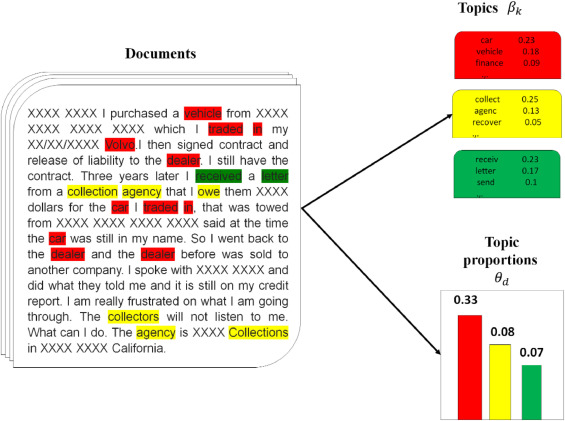</div>
Image from ScienceDirect.com

In [58]:
from time import time
# Fit the LDA model
t0 = time()
lda = LatentDirichletAllocation(n_components=20, random_state=0)
lda.fit(data_vectorized)
joblib.dump(lda, 'lda.dmp')
print("done in %0.3fs." % (time() - t0))

['lda.dmp']

In [59]:
# fit transform the feature matrix
lda_output = lda.fit_transform(data_vectorized)

# display the lda_output and its shape
display(lda_output)
display(lda_output.shape)

array([[7.43052476e-06, 7.43052474e-06, 7.43052474e-06, ...,
        7.43052474e-06, 6.47537309e-02, 4.35157558e-02],
       [3.06065774e-01, 4.81231960e-05, 4.81231960e-05, ...,
        1.70756429e-01, 4.81231965e-05, 4.81231959e-05],
       [1.32100399e-05, 3.15055339e-02, 1.32100399e-05, ...,
        1.32100399e-05, 7.06584289e-03, 1.32100401e-05],
       ...,
       [1.77116545e-05, 1.77116547e-05, 7.30110748e-03, ...,
        1.77116546e-05, 1.77116545e-05, 1.77116547e-05],
       [1.94401247e-05, 1.94401248e-05, 5.48036602e-01, ...,
        1.94401247e-05, 1.94401248e-05, 1.94401248e-05],
       [1.82083034e-05, 1.82083034e-05, 9.34220480e-01, ...,
        1.82083034e-05, 1.82083035e-05, 1.82083033e-05]])

(32619, 20)

In [53]:
doc_topic_dist_lda = pd.DataFrame(lda_output)
doc_topic_dist_lda.to_csv('doc_topic_dist_lda.csv', index=False)

In [60]:
import pyLDAvis.sklearn
panel = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne')
pyLDAvis.display(panel)

In [72]:
pyLDAvis.save_html(panel, outputs_path + 'lda4topics_v2.html')

# Modeling Nearest Neighbor Search in the Topic Space 

In [61]:
def get_k_nearest_docs(doc_dist, k=5, lower=1950, upper=2020, get_dist=False):
    '''
    doc_dist: topic distribution (sums to 1) of one article
    
    Returns the index of the k nearest articles (as by Jensen–Shannon divergence in topic space). 
    '''
    
    relevant_time = df.publish_year.between(lower, upper)    
    temp = doc_topic_dist[relevant_time]        
    distances = temp.apply(lambda x: jensenshannon(x, doc_dist), axis=1)
    k_nearest = distances[distances != 0].nsmallest(n=k).index
    
    if get_dist:
        k_distances = distances[distances != 0].nsmallest(n=k)
        return k_nearest, k_distances
    else:
        return k_nearest

In [62]:
d = get_k_nearest_docs(doc_topic_dist[df.paper_id == 'c83346b9e5e45cc987f59be4e9ad1e63c483ac9a'].iloc[0], get_dist=True)
d

(Int64Index([29363, 31133, 19899, 9970, 3073], dtype='int64'),
 29363    0.028678
 31133    0.060225
 19899    0.077062
 9970     0.098429
 3073     0.113475
 dtype: float64)

In [56]:
df.body_text[4][:2000]

"Viruses continue to pose an important biomedical problem because of the perennial health hazards they present to humans. Although we have made significant progress vaccinating and treating many viral diseases, others remain leading causes of death around the world despite extensive research. Development of effective treatments has remained challenging, in part because of the fact that underlying biophysical principles of viral infection remain poorly understood (1) . Although the life cycle of a typical virus contains many complex steps, ranging from cell entry and replication to eventual lysis and release of progeny virions (2) , this study focuses only on the physical processes by which a virus recognizes and enters its host cell.\nMany envelope viruses are structurally comprised of similar components (3) . The interior of the virus contains RNA/DNA, nucleoproteins, and polymerases required for replication inside the host cell. These are surrounded by matrix proteins that form a pro

In [63]:
df.body_text[29363][:2000]

'Coronaviruses (CoV) represent a diverse family of positive-sense RNA viruses capable of causing respiratory and enteric disease in human and animal hosts. Though there are several human coronaviruses responsible for a mild respiratory disease 1 , most notable are the highly pathogenic human coronaviruses: SARS-CoV and MERS-CoV capable of causing a severe respiratory disease. The zoonotic SARS-CoV emerged into human populations in 2002, spreading to 26 countries during its brief nine month circulation in humans 2 . This epidemic resulted in over 8,000 infections with a ~10% case fatality rate and was eventually contained through public health measures, as there are no specific treatments approved for human coronavirus infections. With the exception of a smaller second SARS-CoV outbreak in 2004 3 , SARS-CoV has been absent from human circulation since the initial outbreak ended. Despite the lack of recent human infections, SARS-CoVlike viruses continue to circulate in bat reservoirs 4 .

In [64]:
df.body_text[31133][:2000]

"Eukaryotic cells express a large panel of proteins that coordinately participate to the cellular machinery through a highly connected and regulated network of protein-protein interactions (1) . Physical architecture of model organisms and human cellular protein networks exhibits a strong robustness against random failures, and strikingly a high sensitivity to targeted attacks on highly connected and central proteins, also called 'hubs' (2, 3) . Cellular protein network is not static and its robustness may change dynamically according to various factors like tissue and cell-line origins, signals received by cellular environment or more specifically during viral infections (4) . Replication and pathogenesis of viruses depend on a complex interplay between viral and host cellular proteins both acting through a complex network of protein-protein interactions. In order to evade the cell innate immune response and/or to favour their own replication and transmission, viruses have developed s